In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

from zipfile import ZipFile
import os

%cd C:\Users\mehmu\Desktop\PyProjects\Projects\github repo\BreastCancer\First Dataset\data
for i in os.listdir('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/BreastCancer/First Dataset/data'):
    if '.zip' in i:
        print(i)
        
        with ZipFile(i, 'r') as zipObj:
            
            zipObj.extractall()
        os.remove(i)

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from sklearn.metrics import roc_auc_score
import warnings

warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(50),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(50),
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/BreastCancer/First Dataset/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                            shuffle=True, num_workers=4)
                    for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes


In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

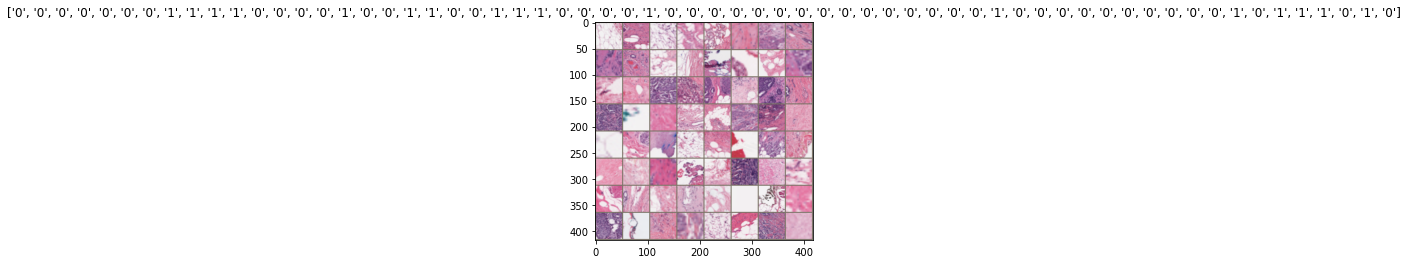

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):


    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_auc=0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    
                    #auc=roc_auc_score(outputs.cpu().max(1)[1],labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #running_auc +=auc.item() * inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            #epoch_auc = running_auc / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f}, epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f} '.format(        
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3411 Acc: 0.8558 
val Loss: 0.2896 Acc: 0.8800 

Epoch 1/24
----------
train Loss: 0.3079 Acc: 0.8706 
val Loss: 0.2807 Acc: 0.8831 

Epoch 2/24
----------
train Loss: 0.2940 Acc: 0.8770 
val Loss: 0.2710 Acc: 0.8878 

Epoch 3/24
----------
train Loss: 0.2881 Acc: 0.8795 
val Loss: 0.2646 Acc: 0.8901 

Epoch 4/24
----------
train Loss: 0.2811 Acc: 0.8824 
val Loss: 0.2610 Acc: 0.8917 

Epoch 5/24
----------
train Loss: 0.2780 Acc: 0.8841 
val Loss: 0.2585 Acc: 0.8934 

Epoch 6/24
----------
train Loss: 0.2740 Acc: 0.8862 
val Loss: 0.2567 Acc: 0.8934 

Epoch 7/24
----------
train Loss: 0.2660 Acc: 0.8894 
val Loss: 0.2489 Acc: 0.8962 

Epoch 8/24
----------
train Loss: 0.2657 Acc: 0.8889 
val Loss: 0.2501 Acc: 0.8962 

Epoch 9/24
----------
train Loss: 0.2640 Acc: 0.8899 
val Loss: 0.2503 Acc: 0.8968 

Epoch 10/24
----------
train Loss: 0.2642 Acc: 0.8895 
val Loss: 0.2467 Acc: 0.8977 

Epoch 11/24
----------
train Loss: 0.2630 Acc: 0.8907 
val Loss:

In [15]:
torch.save(model_ft, 'bcancer_model_24epoch-0.8983acc.h5')

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print(i)
            print([inputs,labels])
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
model_ft=torch.load('bcancer_model_24epoch-0.8983acc.h5')

In [4]:
inputs, classes = next(iter(dataloaders['test']))
inputs

tensor([[[[ 2.0263,  2.0948,  2.0605,  ...,  2.0092,  2.0092,  1.9578],
          [ 2.0263,  2.0434,  2.0434,  ...,  2.0605,  2.0605,  2.0434],
          [ 2.0263,  2.0434,  2.0948,  ...,  2.0777,  2.0263,  2.0605],
          ...,
          [ 1.7352,  1.5982,  1.7694,  ...,  2.0605,  2.0263,  2.0263],
          [ 1.6324,  1.8037,  2.0263,  ...,  2.0605,  2.0605,  2.0605],
          [ 1.7523,  1.6667,  1.9749,  ...,  2.0777,  2.0263,  2.0092]],

         [[ 2.1310,  2.1835,  2.1660,  ...,  2.1134,  2.0609,  1.5882],
          [ 2.1660,  2.2185,  2.1660,  ...,  2.1310,  2.2360,  2.1310],
          [ 2.1660,  2.1660,  2.2185,  ...,  2.2010,  2.1485,  2.1310],
          ...,
          [ 0.2752, -0.1800,  1.0280,  ...,  2.2010,  2.1134,  2.0259],
          [ 0.0826,  0.9930,  1.8508,  ...,  2.2185,  2.2185,  2.1660],
          [ 0.4678,  0.5553,  1.8508,  ...,  2.1660,  2.1485,  2.2010]],

         [[ 2.4308,  2.3786,  2.4831,  ...,  2.3611,  2.3960,  1.9951],
          [ 2.3960,  2.4308,  

In [5]:
inputs.size()

torch.Size([64, 3, 50, 50])

In [6]:
model_ft.eval()
pred=model_ft(inputs.to(device)).max(1)[1]


In [8]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score

df=pd.DataFrame(columns=['f1','accuracy_score','recall_score','AUC'])

for _ in range(50):
    inputs, classes = next(iter(dataloaders['test']))
    model_ft.eval()
    pred=model_ft(inputs.to(device)).max(1)[1]
    f=f1_score(pred.cpu(),classes)
    a=accuracy_score(pred.cpu(),classes)
    r=recall_score(pred.cpu(),classes)
    auc=roc_auc_score(pred.cpu(),classes)
    df.loc[len(df.index)]=[f,a,r,auc]

df

In [9]:
print('f1: ', df.f1.mean())
print('accuracy_score: ', df.accuracy_score.mean())
print('recall: ', df.recall_score.mean())
print('AUC: ', df.AUC.mean())

f1:  0.8134453697385277
accuracy_score:  0.904375
recall:  0.8425581402601527
AUC:  0.8837029042295375
